In [4]:
class HorseResults:
    def __init__(self, horse_results):
        self.horse_results = horse_results[["日付", "着順", "賞金"]]
        self.preprocessing()
        # self.horse_results.rename(columns={'着順':'着順（平均）','賞金':'賞金（平均）'},inplace=True)

    def preprocessing(self):
        df = self.horse_results.copy()

        # 着順に数字以外の文字列が含まれているものを取り除く
        df["着順"] = pd.to_numeric(df["着順"], errors="coerce")
        df.dropna(subset=["着順"], inplace=True)
        df["着順"] = df["着順"].astype(int)

        df["date"] = pd.to_datetime(df["日付"])
        df.drop(["日付"], axis=1, inplace=True)
        df["賞金"].fillna(0, inplace=True)
        self.horse_results = df

    def average(self, horse_id_list, date, n_samples="all"):
        target_df = self.horse_results.loc[horse_id_list]

        if n_samples == "all":
            filtered_df = target_df[target_df["date"] < date]
        elif n_samples > 0:
            filtered_df = (
                target_df[target_df["date"] < date]
                .sort_values("date", ascending=False)
                .groupby(level=0)
                .head(n_samples)
            )
        else:
            raise Exception("正の値のみ")

        ave = filtered_df.groupby(level=0)[["着順", "賞金"]].mean()
        return ave.rename(
            columns={
                "着順": "着順平均{}R分".format(n_samples),
                "賞金": "賞金平均{}R分".format(n_samples),
            }
        )

    def merge(self, results, date, n_samples="all"):
        df = results[results["date"] == date]
        horse_id_list = df["horse_id"]
        merged_df = df.merge(
            self.average(horse_id_list, date, n_samples),
            left_on="horse_id",
            right_index=True,
            how="left",
        )
        return merged_df

    def merge_all(self, results, n_samples="all"):
        date_list = results["date"].unique()
        merged_df = pd.concat(
            [self.merge(results, date, n_samples) for date in date_list]
        )
        return merged_df

In [74]:
import datetime


def preprocessing(results):
    df = results.copy()

    # 着順に数字以外の文字列が含まれているものを取り除く
    df = df[~(df["着順"].astype(str).str.contains("\D"))]
    df["着順"] = df["着順"].astype(int)

    # 性齢を性と年齢に分ける
    df["性"] = df["性齢"].map(lambda x: str(x)[0])
    df["年齢"] = df["性齢"].map(lambda x: str(x)[1:]).astype(int)

    # 馬体重を体重と体重変化に分ける
    df["体重"] = df["馬体重"].str.split("(", expand=True)[0].astype(int)
    df["体重変化"] = df["馬体重"].str.split("(", expand=True)[1].str[:-1].astype(int)

    # データをint, floatに変換
    df["単勝"] = df["単勝"].astype(float)

    # 不要な列を削除
    df.drop(["タイム", "着差", "調教師", "性齢", "馬体重", "馬名", "騎手"], axis=1, inplace=True)

    df["date"] = pd.to_datetime(df["date"], format="%Y年%m月%d日")
    return df


def split_data(df, test_size=0.3):
    sorted_id_list = df.sort_values("date").index.unique()
    train_id_list = sorted_id_list[: round(len(sorted_id_list) * (1 - test_size))]
    test_id_list = sorted_id_list[round(len(sorted_id_list) * (1 - test_size)) :]
    train = df.loc[train_id_list].drop(["date"], axis=1)
    test = df.loc[test_id_list].drop(["date"], axis=1)
    return train, test

In [3]:
import pandas as pd

results = pd.read_pickle("results_id.pickle")
results_p = preprocessing(results)
horse = pd.read_pickle("horse_results.pickle")
horse_p = HorseResults(horse)
horse_p.merge_all(results_p, 5)

,着順,枠番,馬番,斤量,単勝,人気,horse_id,jockey_id,course_len,weather,race_type,ground_state,date,性,年齢,体重,体重変化,着順平均5R分,賞金平均5R分
201901010101,1,1,1,54.0,1.4,1.0,2017105318,05339,1800,曇,芝,良,2019-07-27,牡,2,518,-16,3.0,180.00
201901010101,2,3,3,54.0,3.5,2.0,2017104612,05203,1800,曇,芝,良,2019-07-27,牡,2,496,-8,2.0,280.00
201901010101,3,4,4,51.0,46.6,6.0,2017103879,01180,1800,曇,芝,良,2019-07-27,牡,2,546,6,10.0,0.00
201901010101,4,8,9,51.0,56.8,7.0,2017106259,01179,1800,曇,芝,良,2019-07-27,牡,2,458,-8,4.0,110.00
201901010101,5,5,5,54.0,140.3,9.0,2017104140,01062,1800,曇,芝,良,2019-07-27,牡,2,436,0,9.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201908040412,5,5,5,57.0,15.4,7.0,2014102848,01092,1800,晴,ダート,重,2019-10-13,牡,5,492,-10,4.4,442.36
201908040412,6,2,2,57.0,36.0,9.0,2012100555,01126,1800,晴,ダート,重,2019-10-13,牡,7,526,2,6.2,239.98
201908040412,7,1,1,57.0,7.2,4.0,2014105543,01122,1800,晴,ダート,重,2019-10-13,牡,5,498,-4,4.2,477.96
201908040412,8,4,4,55.0,23.9,8.0,2013103613,05429,1800,晴,ダート,重,2019-10-13,牝,6,504,0,7.2,146.58


In [15]:
s = horse_p.horse_results
s = s.sort_values("date", ascending=False).groupby(level=0).head(3)
s.loc["2017106325"]

,着順（平均）,賞金（平均）,date
2017106325,2,32.0,2021-05-26
2017106325,4,13.5,2021-05-12
2017106325,2,32.0,2021-04-27


In [36]:
hr=HorseResults(horse)
results_3R=hr.merge_all(results_p,n_samples=3)
results_3R.head()

,着順,枠番,馬番,馬名,斤量,騎手,単勝,人気,horse_id,jockey_id,...,weather,race_type,ground_state,date,性,年齢,体重,体重変化,着順平均3R分,賞金平均3R分
201901010101,1,1,1,ゴルコンダ,54.0,ルメール,1.4,1.0,2017105318,05339,...,曇,芝,良,2019-07-27,牡,2,518,-16,3.0,180.0
201901010101,2,3,3,プントファイヤー,54.0,岩田康誠,3.5,2.0,2017104612,05203,...,曇,芝,良,2019-07-27,牡,2,496,-8,2.0,280.0
201901010101,3,4,4,ラグリマスネグラス,51.0,団野大成,46.6,6.0,2017103879,01180,...,曇,芝,良,2019-07-27,牡,2,546,6,10.0,0.0
201901010101,4,8,9,キタノコドウ,51.0,菅原明良,56.8,7.0,2017106259,01179,...,曇,芝,良,2019-07-27,牡,2,458,-8,4.0,110.0
201901010101,5,5,5,ネモフィラブルー,54.0,川島信二,140.3,9.0,2017104140,01062,...,曇,芝,良,2019-07-27,牡,2,436,0,9.0,0.0


In [29]:
a=results_3R
a[a['horse_id']=="2017105318"]

,着順,枠番,馬番,馬名,斤量,騎手,単勝,人気,horse_id,jockey_id,...,weather,race_type,ground_state,date,性,年齢,体重,体重変化,着順（平均）,賞金（平均）
201901010101,1,1,1,ゴルコンダ,54.0,ルメール,1.4,1.0,2017105318,05339,...,曇,芝,良,2019-07-27,牡,2,518,-16,3.0,180.0
201901020511,6,7,10,ゴルコンダ,54.0,ルメール,1.8,1.0,2017105318,05339,...,曇,芝,稍重,2019-08-31,牡,2,524,6,2.0,340.0
201905030405,3,4,4,ゴルコンダ,54.0,レーン,4.8,2.0,2017105318,05585,...,曇,芝,稍重,2019-06-09,牡,2,534,0,NaN,NaN


In [89]:
hr=HorseResults(horse)
results_5R=hr.merge_all(results_p,n_samples=5)
results_5R["rank"]=results_5R["着順"].map(lambda x: 1 if x<4 else 0)
results_5R.drop(["着順","horse_id"],axis=1,inplace=True)
results_5R

,枠番,馬番,斤量,単勝,人気,jockey_id,course_len,weather,race_type,ground_state,date,性,年齢,体重,体重変化,着順平均5R分,賞金平均5R分,rank
201901010101,1,1,54.0,1.4,1.0,05339,1800,曇,芝,良,2019-07-27,牡,2,518,-16,3.0,180.00,1
201901010101,3,3,54.0,3.5,2.0,05203,1800,曇,芝,良,2019-07-27,牡,2,496,-8,2.0,280.00,1
201901010101,4,4,51.0,46.6,6.0,01180,1800,曇,芝,良,2019-07-27,牡,2,546,6,10.0,0.00,1
201901010101,8,9,51.0,56.8,7.0,01179,1800,曇,芝,良,2019-07-27,牡,2,458,-8,4.0,110.00,0
201901010101,5,5,54.0,140.3,9.0,01062,1800,曇,芝,良,2019-07-27,牡,2,436,0,9.0,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201908040412,5,5,57.0,15.4,7.0,01092,1800,晴,ダート,重,2019-10-13,牡,5,492,-10,4.4,442.36,0
201908040412,2,2,57.0,36.0,9.0,01126,1800,晴,ダート,重,2019-10-13,牡,7,526,2,6.2,239.98,0
201908040412,1,1,57.0,7.2,4.0,01122,1800,晴,ダート,重,2019-10-13,牡,5,498,-4,4.2,477.96,0
201908040412,4,4,55.0,23.9,8.0,05429,1800,晴,ダート,重,2019-10-13,牝,6,504,0,7.2,146.58,0


In [90]:
results_d=pd.get_dummies(results_5R)

In [143]:
train,test=split_data(results_d)
X_train=train.drop(["rank"],axis=1)
y_train=train["rank"]
X_test=test.drop(["rank"],axis=1)
y_test=test["rank"]

In [140]:
#X_train.fillna(0,inplace=True)
#y_train.fillna(0,inplace=True)

201908010105    1
201908010105    1
201908010105    1
201908010105    0
201908010105    0
               ..
201906040208    0
201906040208    0
201906040208    0
201906040208    0
201906040208    0
Name: rank, Length: 30432, dtype: int64

In [91]:
#dateがあるとエラー
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
params={
    'num_leaves':4,
    'n_estimators':80,
    'class_weight':'balanced',
    'random_state':100
}
lgb_clf=lgb.LGBMClassifier(**params)
lgb_clf.fit(X_train.values,y_train.values)
y_pred_train=lgb_clf.predict_proba(X_train)[:,1]
y_pred=lgb_clf.predict_proba(X_test)[:,1]
print(roc_auc_score(y_train,y_pred_train))
print(roc_auc_score(y_test,y_pred))

1.0
1.0


In [44]:
importances=pd.DataFrame({'features':X_train.columns,"importance":lgb_clf.feature_importances_})
importances.sort_values('importance',ascending=False)[:20]

,features,importance
3,単勝,115
8,着順平均5R分,25
4,人気,19
6,体重,15
9,賞金平均5R分,11
5,年齢,7
7,体重変化,7
130,jockey_id_01164,6
1,馬番,3
2,斤量,3


In [45]:
url="https://db.netkeiba.com/race/201901020101"
pd.read_html(url)[1]

,0,1,2,3
0,単勝,7,890,2
1,複勝,715,180110470,218
2,枠連,1 - 7,450,2
3,馬連,1 - 7,480,1


In [48]:
from urllib.request import urlopen
f=urlopen(url)
html=f.read()
html=html.replace(b'<br />',b'br')
pd.read_html(html)[1]

,0,1,2,3
0,単勝,7,890,2
1,複勝,7br1br5,180br110br470,2br1br8
2,枠連,1 - 7,450,2
3,馬連,1 - 7,480,1


In [83]:
import time
from tqdm.notebook import tqdm
from urllib.request import urlopen

def scrape_return_tables(race_id_list, pre_return_tables={}):
    return_tables = pre_return_tables
    for race_id in tqdm(race_id_list):
        if race_id in return_tables.keys():
            continue
        try:
            time.sleep(1)
            url = "https://db.netkeiba.com/race/" + race_id
            f=urlopen(url)
            html=f.read()
            html=html.replace(b'<br />',b'br')
            dfs=pd.read_html(html)
            return_tables[race_id] = pd.concat([dfs[1],dfs[2]])
        except IndexError:
            continue
        except Exception as e:
            print(e)
        except:
            break
    return return_tables

In [86]:
train,test=split_data(results_p)
race_id_list=test.index.unique()
test=scrape_return_tables(race_id_list)

  0%|          | 0/956 [00:00<?, ?it/s]

In [89]:
tes2=test
for key in tes2:
    tes2[key].index = [key] * len(tes2[key])
return_tables = pd.concat([tes2[key] for key in tes2], sort=False) 

In [91]:
return_tables.to_pickle('return_tables.pickle')

In [107]:
a=pd.read_pickle("return_tables.pickle")

In [111]:
class Return:
    def __init__(self, return_tables):
        self.return_tables=return_tables
    
    @property
    def fukusho(self):
        fukusho=self.return_tables[self.return_tables[0]=="複勝"][[1,2]]
        wins=fukusho[1].str.split('br',expand=True).drop([3],axis=1)
        wins.columns=['win_0','win_1','win_2']
        returns=fukusho[2].str.split('br',expand=True).drop([3],axis=1)
        returns.columns=['return_0','return_1','return_2']
        df=pd.concat([wins,returns],axis=1)
        for column in df.columns:
            df[column]=df[column].str.replace(',','')
        return df.fillna(0).astype(int)
    
    @property
    def tansho(self):
        tansho=self.return_tables[self.return_tables[0]=="単勝"][[1,2]]
        tansho.columns=["win","return"]
        
        for column in tansho.columns:
            tansho[column]=pd.to_numeric(tansho[column],errors="coerce")
        return tansho

In [114]:
r=Return(a)
r.tansho.info()

<class 'pandas.core.frame.DataFrame'>
Index: 960 entries, 201908010112 to 201909050809
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   win     959 non-null    float64
 1   return  959 non-null    float64
dtypes: float64(2)
memory usage: 22.5+ KB


In [101]:
pd.to_numeric(r.tansho["win"],errors="coerce").isnull().sum()

1

In [115]:
from sklearn.metrics import roc_auc_score

class ModelEvaluator:
    def __init__(self,model,return_tables):
        self.model=model
        self.fukusho=Return(return_tables).fukusho
        self.tansho=Return(return_tables).tansho
        
    def predict_proba(self,X):
        return self.model.predict_proba(X)[:,1]
        
    def predict(self,X,threshold=0.5):
        y_pred=self.predict_proba(X)
        return [0 if p<threshold else 1 for p in y_pred]
    
    def score(self,y_true,X):
        return roc_auc_score(y_true,self.predict_proba(X))
    
    def feature_importance(self,X,n_display=20):
        importances=pd.DataFrame({'features':X.columns,"importance":self.model.feature_importances_})
        return importances.sort_values('importance',ascending=False)[:n_display]
    
    def pred_table(self,X,threshold=0.5,bet_only=True):
        pred_table=X.copy()[['馬番']] #[]２回でDF、１回でシリーズ型
        pred_table["pred"]=self.predict(X,threshold)
        if bet_only:
            return pred_table[pred_table["pred"]==1]["馬番"]
        else:
            return pred_table
    
    def fukusho_return(self,X,threshold=0.5):
        pred_table=self.pred_table(X,threshold)
        n_bets=len(pred_table)
        money=-100*n_bets
        df=self.fukusho.copy()
        df=df.merge(pred_table,left_index=True,right_index=True,how='right')
        for i in range(3):
            money+=df[df["win_{}".format(i)]==df["馬番"]]['return_{}'.format(i)].sum()
        return n_bets,money
        
    def tansho_return(self,X,threshold=0.5):
        pred_table=self.pred_table(X,threshold)
        n_bets=len(pred_table)
        money=-100*n_bets
        df=self.tansho.copy()
        df=df.merge(pred_table,left_index=True,right_index=True,how='right')
        money+=df[df["win"]==df["馬番"]]['return'].sum()
        return n_bets,money

In [116]:
me=ModelEvaluator(lgb_clf,return_tables)

In [117]:
gain_tansho=gain(me.tansho_return , X_test)

  0%|          | 0/100 [00:00<?, ?it/s]

<AxesSubplot:>

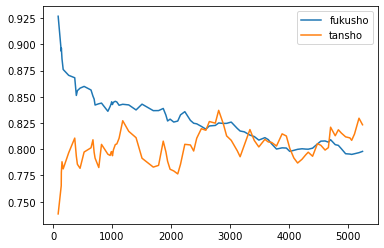

In [120]:
g.rename("fukusho").plot(legend=True)
gain_tansho.rename("tansho").plot(legend=True)

In [48]:
me=ModelEvaluator(lgb_clf,return_tables)
me.predict_proba(X_test)
me.score(y_train,X_train)
me.score(y_test,X_test)
me.feature_importance(X_train)
me.predict(X_test)
me.pred_table(X_test)
me.calc_return(X_test)

(2870, 666330.0)

In [67]:
me=ModelEvaluator(lgb_clf,return_tables)
me.score(y_test,X_test)

1.0

In [183]:
gain={}
n_samples=100
for i in tqdm(range(n_samples)):
    threshold=i/n_samples
    gain[threshold]=me.calc_return(X_test,threshold)

  0%|          | 0/100 [00:00<?, ?it/s]

<AxesSubplot:>

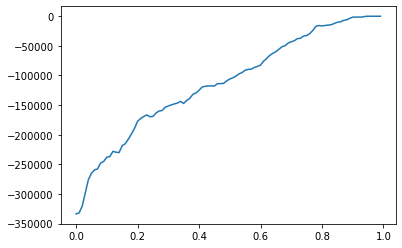

In [184]:
pd.Series(gain).plot()

In [3]:
import pandas as pd
results=pd.read_pickle("results_id.pickle")

In [5]:
horse_id_list=results["horse_id"].unique()

In [6]:
len(horse_id_list)

11401

In [34]:
import time
from tqdm.notebook import tqdm
from urllib.request import urlopen

def scrape_peds(horse_id_list, pre_peds={}):
    peds=pre_peds
    for horse_id in tqdm(horse_id_list):
        if horse_id in peds.keys():
            continue
        try:
            time.sleep(1)
            url = "https://db.netkeiba.com/horse/ped/" + horse_id
            df=pd.read_html(url)[0]
            
            generations={}
            for i in range(5)[::-1]:
                generations[i]=df[i]
                df.drop([i],axis=1,inplace=True)
                df=df.drop_duplicates()
            ped=pd.concat([generations[i] for i in range(5)]).rename(horse_id)
            peds[horse_id]=ped.reset_index(drop=True)
    
        except IndexError:
            continue
        except Exception as e:
            print(e)
            break
    return peds

In [42]:
peds=scrape_peds(horse_id_list)

  0%|          | 0/11401 [00:00<?, ?it/s]

In [43]:
pre=peds
bloods=pd.concat([peds[horse_id] for horse_id in peds],axis=1).T
bloods=bloods.add_prefix("peds_")
bloods.to_pickle("peds.pickle")

In [45]:
len(peds)

11401

In [46]:
x=pd.read_pickle("peds.pickle")
x

,peds_0,peds_1,peds_2,peds_3,peds_4,peds_5,peds_6,peds_7,peds_8,peds_9,...,peds_52,peds_53,peds_54,peds_55,peds_56,peds_57,peds_58,peds_59,peds_60,peds_61
2017105318,ヴィクトワールピサ 2007 黒鹿毛 [血統][産駒] Halo系,ゴレラ Gorella(仏) 2002 栗毛 [血統][産駒] FNo.[9-e],ネオユニヴァース 2000 鹿毛 [血統][産駒],ホワイトウォーターアフェア Whitewater Affair(英) 1993 栗毛 [血統...,Grape Tree Road 1993 鹿毛 [血統][産駒],Exciting Times 1997 栗毛 [血統][産駒],サンデーサイレンス Sunday Silence(米) 1986 青鹿毛 [血統][産駒],ポインテッドパス Pointed Path(英) 1984 栗毛 [血統][産駒],Machiavellian 1987 黒鹿毛 [血統][産駒],Much Too Risky 1982 栗毛 [血統][産駒],...,Busted,Tina,Northern Dancer,Special,Alydar,Crimson Saint,High Top,Sega Ville,Sir Gaylord,Crepellana
2017104612,エピファネイア 2010 鹿毛 [血統][産駒] Roberto系,プントバンコ 2008 青鹿毛 [血統][産駒] FNo.[10-a],シンボリクリスエス 1999 黒鹿毛 [血統][産駒],シーザリオ 2002 青毛 [血統][産駒],フジキセキ 1992 青鹿毛 [血統][産駒],ポリーズフリート Polly's Fleet(米) 1995 栗毛 [血統][産駒],Kris S. 1977 黒鹿毛 [血統][産駒],Tee Kay 1991 黒鹿毛 [血統][産駒],スペシャルウィーク 1995 黒鹿毛 [血統][産駒],キロフプリミエール Kirov Premiere(英) 1990 鹿毛 [血統][産駒],...,In Reality,Millicent,Raise a Native,Gold Digger,Venetian Jester,Friendly Ways,Northern Dancer,Goofed,Hard Tack,Polly Macaw
2017103879,カジノドライヴ 2005 栗毛 [血統][産駒] Seattle Slew系,フォレノワール 2010 鹿毛 [血統][産駒] FNo.[19-b],Mineshaft (米) 1999 黒鹿毛 [血統][産駒],Better Than Honour 1996 鹿毛 [血統][産駒],アグネスタキオン 1998 栗毛 [血統][産駒],ネームヴァリュー 1998 鹿毛 [血統][産駒],A.P. Indy 1989 黒鹿毛 [血統][産駒],Prospectors Delite 1989 [血統][産駒],Deputy Minister 1979 黒鹿毛 [血統][産駒],Blush With Pride 1979 栗毛 [血統][産駒],...,リマンド,イコマエイカン,In Reality,Foggy Note,Al Nasr,Gonfalon,Bold Reasoning,My Charmer,Graustark,Queen's Paradise
2017106259,クロフネ 1998 芦毛 [血統][産駒] Deputy Minister系,オースミフブキ 2011 鹿毛 [血統][産駒] FNo.[3-l],フレンチデピュティ French Deputy(米) 1992 栗毛 [血統][産駒],ブルーアヴェニュー Blue Avenue(米) 1990 芦毛 [血統][産駒],マンハッタンカフェ 1998 青鹿毛 [血統][産駒],オースミハルカ 2000 鹿毛 [血統][産駒],Deputy Minister 1979 黒鹿毛 [血統][産駒],Mitterand 1981 鹿毛 [血統][産駒],Classic Go Go 1978 黒鹿毛 [血統][産駒],Eliza Blue 1983 芦毛 [血統][産駒],...,Luciano,Suleika,Nijinsky,Foreseer,Sadler's Wells,Sun Princess,Alydar,ベーシイド,プロント,トサモアー
2017104140,オーシャンブルー 2008 鹿毛 [血統][産駒] Halo系,ロックマイハート Rock My Heart(独) 2009 栗毛 [血統][産駒] FNo...,ステイゴールド 1994 黒鹿毛 [血統][産駒],プアプー Peu a Peu(独) 1998 鹿毛 [血統][産駒],Sholokhov 1999 鹿毛 [血統][産駒],Rondinay 2000 栗毛 [血統][産駒],サンデーサイレンス Sunday Silence(米) 1986 青鹿毛 [血統][産駒],ゴールデンサッシュ 1988 栗毛 [血統][産駒],Dashing Blade 1987 鹿毛 [血統][産駒],Plains Indian 1991 鹿毛 [血統][産駒],...,Home Guard,Gradiva,Balidar,Brig O'Doon,Sharpen Up,L'Anguissola,Surumu,Aggravate,Prince Ippi,Tania
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014103978,カネヒキリ 2002 栗毛 [血統][産駒] Halo系,チリビリビン 2001 栗毛 [血統][産駒] FNo.[3-d],フジキセキ 1992 青鹿毛 [血統][産駒],ライフアウトゼア Life Out There(米) 1992 栗毛 [血統][産駒],ブロッコ Brocco(米) 1991 栗毛 [血統][産駒],スイートバンブー 1994 栗毛 [血統][産駒],サンデーサイレンス Sunday Silence(米) 1986 青鹿毛 [血統][産駒],ミルレーサー Millracer(米) 1983 鹿毛 [血統][産駒],Deputy Minister 1979 黒鹿毛 [血統][産駒],Silver Valley 1979 栗毛 [血統][産駒],...,Anyoldtime,Cold Hands,Raise a Native,Gold Digger,Nijinsky,Foreseer,Shecky Greene,Tell Meno Lies,Cornish Prince,Chocolate Beau
2013104167,ヴィクトワールピサ 2007 黒鹿毛 [血統][産駒] Halo系,プレシャスキャット Precious Cat(米) 1996 栗毛 [血統][産駒] FNo...,ネオユニヴァース 2000 鹿毛 [血統][産駒],ホワイトウォーターアフェア Whitewater Affair(英) 1993 栗毛 [血統...,Storm Cat (米) 1983 黒鹿毛 [血統][産駒],Nurse Lulu 1981 栗毛 [血統][産駒],サンデーサイレンス Sunday Silence(米) 1986 青鹿毛 [血統][産駒],ポインテッドパス Pointed Path(英) 1984 栗毛 [血統][産駒],Machiavellian 1987 黒鹿毛 [血統][産駒],Much Too Risky 1982 栗毛 [血統][産駒],...,Crimson Satan,Bolero Rose,Nasrullah,Miss Disco,Precipitation,Marita,Rough'n Tumble,Aspidistra,Damascus,Romanita
2016103109,ナカヤマフェスタ 2006 鹿毛 [血統][産駒] Halo系,プリスティン Pristine(米) 1998 黒鹿毛 [血統][産駒] FNo.[4-m],ステイゴールド 1994 黒鹿毛 [血統][産駒],ディアウィンク 1998 鹿毛 [血統][産駒],Gone West 1984 鹿毛 [血統][産駒],Existentialist 1989 黒鹿毛 [血統][産駒],サンデーサイレンス Sunday Silence(米) 1986 青鹿毛 [血統][産駒],ゴールデンサッシュ 1988 栗毛 [血統][産駒],タイトスポット Tight Spot(米) 1987 鹿毛 [血統][産駒],セイレイ 1991 鹿毛 [血統][産駒],...,Tim Tam,Mixed Marriage,Intentionally,My Dear Girl,The Axe,Silver Song,Khaled,Iron Reward,War Admiral,Carillon
2017102954,ジャスタウェイ 2009 鹿毛 [血統][産駒] Halo系,ファーレサルティ 2006 黒鹿毛 [血統][産駒] FNo.

In [23]:
sample=peds['2017105318']
sample.drop_duplicates()[3]

0              Halo 1969 黒鹿毛
2       Wishing Well 1975 鹿毛
4               Kris 1976 栗毛
6         Silken Way 1973 栗毛
8     Mr. Prospector 1970 鹿毛
10     Coup de Folie 1982 鹿毛
12           Bustino 1971 鹿毛
14    Short Rations 1975 黒鹿毛
16          Nijinsky 1967 鹿毛
18         Foreseer 1969 黒鹿毛
20           Habitat 1966 鹿毛
22        Guillotina 1969 鹿毛
24           Nureyev 1977 鹿毛
26         Alydariel 1983 栗毛
28         Top Ville 1976 鹿毛
30          Eurissia 1975 鹿毛
Name: 3, dtype: object

In [8]:
hr = HorseResults(horse)
results_m=hr.merge_all(results_p,n_samples=5)
results_m["rank"]=results_m["着順"].map(lambda x:1 if x<4 else 0)
results_m.drop(["着順"],axis=1,inplace=True)
results_m.head()

,枠番,馬番,斤量,単勝,人気,horse_id,jockey_id,course_len,weather,race_type,ground_state,date,性,年齢,体重,体重変化,着順平均5R分,賞金平均5R分,rank
201901010101,1,1,54.0,1.4,1.0,2017105318,05339,1800,曇,芝,良,2019-07-27,牡,2,518,-16,3.0,180.0,1
201901010101,3,3,54.0,3.5,2.0,2017104612,05203,1800,曇,芝,良,2019-07-27,牡,2,496,-8,2.0,280.0,1
201901010101,4,4,51.0,46.6,6.0,2017103879,01180,1800,曇,芝,良,2019-07-27,牡,2,546,6,10.0,0.0,1
201901010101,8,9,51.0,56.8,7.0,2017106259,01179,1800,曇,芝,良,2019-07-27,牡,2,458,-8,4.0,110.0,0
201901010101,5,5,54.0,140.3,9.0,2017104140,01062,1800,曇,芝,良,2019-07-27,牡,2,436,0,9.0,0.0,0


In [10]:
results_m["horse_id"].astype('category')

201901010101    2017105318
201901010101    2017104612
201901010101    2017103879
201901010101    2017106259
201901010101    2017104140
                   ...    
201908040412    2014102848
201908040412    2012100555
201908040412    2014105543
201908040412    2013103613
201908040412    2015101394
Name: horse_id, Length: 43302, dtype: category
Categories (11345, object): ['2007100107', '2008100889', '2008104268', '2009100502', ..., '2017110171', '2017110172', '2017110173', '2017110175']

In [12]:
from sklearn.preprocessing import LabelEncoder

LabelEncoder().fit_transform(results_m["horse_id"])

array([10493, 10088,  9755, ...,  1977,   739,  2550])

In [14]:
results_m["horse_id"]=LabelEncoder().fit_transform(results_m["horse_id"])
results_m["horse_id"]

201901010101    10493
201901010101    10088
201901010101     9755
201901010101    10945
201901010101     9869
                ...  
201908040412     1529
201908040412      188
201908040412     1977
201908040412      739
201908040412     2550
Name: horse_id, Length: 43302, dtype: int64

In [15]:
results_d=pd.get_dummies(results_m)
results_d.head()

,枠番,馬番,斤量,単勝,人気,horse_id,date,年齢,体重,体重変化,...,race_type_ダート,race_type_芝,race_type_障害,ground_state_不良,ground_state_稍重,ground_state_良,ground_state_重,性_セ,性_牝,性_牡
201901010101,1,1,54.0,1.4,1.0,10493,2019-07-27,2,518,-16,...,0,1,0,0,0,1,0,0,0,1
201901010101,3,3,54.0,3.5,2.0,10088,2019-07-27,2,496,-8,...,0,1,0,0,0,1,0,0,0,1
201901010101,4,4,51.0,46.6,6.0,9755,2019-07-27,2,546,6,...,0,1,0,0,0,1,0,0,0,1
201901010101,8,9,51.0,56.8,7.0,10945,2019-07-27,2,458,-8,...,0,1,0,0,0,1,0,0,0,1
201901010101,5,5,54.0,140.3,9.0,9869,2019-07-27,2,436,0,...,0,1,0,0,0,1,0,0,0,1


In [17]:
results_d["horse_id"]=results_d["horse_id"].astype("category")
results_d.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43302 entries, 201901010101 to 201908040412
Columns: 262 entries, 枠番 to 性_牡
dtypes: category(1), datetime64[ns](1), float64(5), int32(3), int64(3), uint8(249)
memory usage: 15.5+ MB


In [20]:
#dateがあるとエラー
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
params={
    'num_leaves':4,
    'n_estimators':80,
    'class_weight':'balanced',
    'random_state':100
}
lgb_clf=lgb.LGBMClassifier(**params)
lgb_clf.fit(X_train.values,y_train.values)

LGBMClassifier(class_weight='balanced', n_estimators=80, num_leaves=4,
               random_state=100)

In [30]:
return_tables=pd.read_pickle("return_tables.pickle")

In [23]:
me=ModelEvaluator(lgb_clf,return_tables)
me.feature_importance(X_test)

,features,importance
3,単勝,116
9,着順平均5R分,24
4,人気,19
7,体重,13
10,賞金平均5R分,10
5,horse_id,8
8,体重変化,6
131,jockey_id_01164,6
6,年齢,4
1,馬番,4


In [25]:
peds=pd.read_pickle("peds.pickle")

In [39]:
hr = HorseResults(horse)
results_m=hr.merge_all(results_p,n_samples=5)

In [40]:
results_m=results_m.merge(peds,left_on='horse_id',right_index=True,how='left')
results_m.head()

,着順,枠番,馬番,斤量,単勝,人気,horse_id,jockey_id,course_len,weather,...,peds_52,peds_53,peds_54,peds_55,peds_56,peds_57,peds_58,peds_59,peds_60,peds_61
201901010101,1,1,1,54.0,1.4,1.0,2017105318,05339,1800,曇,...,Busted,Tina,Northern Dancer,Special,Alydar,Crimson Saint,High Top,Sega Ville,Sir Gaylord,Crepellana
201901010101,2,3,3,54.0,3.5,2.0,2017104612,05203,1800,曇,...,In Reality,Millicent,Raise a Native,Gold Digger,Venetian Jester,Friendly Ways,Northern Dancer,Goofed,Hard Tack,Polly Macaw
201901010101,3,4,4,51.0,46.6,6.0,2017103879,01180,1800,曇,...,リマンド,イコマエイカン,In Reality,Foggy Note,Al Nasr,Gonfalon,Bold Reasoning,My Charmer,Graustark,Queen's Paradise
201901010101,4,8,9,51.0,56.8,7.0,2017106259,01179,1800,曇,...,Luciano,Suleika,Nijinsky,Foreseer,Sadler's Wells,Sun Princess,Alydar,ベーシイド,プロント,トサモアー
201901010101,5,5,5,54.0,140.3,9.0,2017104140,01062,1800,曇,...,Home Guard,Gradiva,Balidar,Brig O'Doon,Sharpen Up,L'Anguissola,Surumu,Aggravate,Prince Ippi,Tania


In [29]:
results_m["peds_0"].isnull().sum()

0

In [31]:
categorical_columns=["horse_id"]+list(peds.columns)
categorical_columns

['horse_id',
 'peds_0',
 'peds_1',
 'peds_2',
 'peds_3',
 'peds_4',
 'peds_5',
 'peds_6',
 'peds_7',
 'peds_8',
 'peds_9',
 'peds_10',
 'peds_11',
 'peds_12',
 'peds_13',
 'peds_14',
 'peds_15',
 'peds_16',
 'peds_17',
 'peds_18',
 'peds_19',
 'peds_20',
 'peds_21',
 'peds_22',
 'peds_23',
 'peds_24',
 'peds_25',
 'peds_26',
 'peds_27',
 'peds_28',
 'peds_29',
 'peds_30',
 'peds_31',
 'peds_32',
 'peds_33',
 'peds_34',
 'peds_35',
 'peds_36',
 'peds_37',
 'peds_38',
 'peds_39',
 'peds_40',
 'peds_41',
 'peds_42',
 'peds_43',
 'peds_44',
 'peds_45',
 'peds_46',
 'peds_47',
 'peds_48',
 'peds_49',
 'peds_50',
 'peds_51',
 'peds_52',
 'peds_53',
 'peds_54',
 'peds_55',
 'peds_56',
 'peds_57',
 'peds_58',
 'peds_59',
 'peds_60',
 'peds_61']

In [32]:
from sklearn.preprocessing import LabelEncoder

for column in categorical_columns:
    results_m[column]=LabelEncoder().fit_transform(results_m[column])

In [35]:
results_d=pd.get_dummies(results_m)

In [36]:
for column in categorical_columns:
    results_d[column]=results_d[column].astype("category")

In [37]:
results_d.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43302 entries, 201901010101 to 201908040412
Columns: 324 entries, 着順 to 性_牡
dtypes: category(63), datetime64[ns](1), float64(5), int32(4), int64(2), uint8(249)
memory usage: 20.8+ MB


In [68]:
from sklearn.preprocessing import LabelEncoder
def process_categorical(df,target_columns):
    df2=df.copy()
    for column in target_columns:
        df2[column]=LabelEncoder().fit_transform(df2[column].fillna("Na"))
        
    #target_columns以外にカテゴリ変数があれば、ダミー変数にする。
    df2=pd.get_dummies(df2)
    
    for column in target_columns:
        df2[column]=df2[column].astype("category")
    return df2

In [41]:
results_c=process_categorical(results_m,categorical_columns)
results_c.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43302 entries, 201901010101 to 201908040412
Columns: 324 entries, 着順 to 性_牡
dtypes: category(63), datetime64[ns](1), float64(5), int32(4), int64(2), uint8(249)
memory usage: 20.8+ MB


In [80]:
results_d["rank"]=results_d["着順"].map(lambda x:1 if x<4 else 0)
train,test=split_data(results_d)
X_train=train.drop(["rank"],axis=1)
y_train=train["rank"]
X_test=test.drop(["rank"],axis=1)
y_test=test["rank"]

In [86]:
me=ModelEvaluator(lgb_clf,return_tables)
gain(me.calc_return,X_test).plot()　#着順をdropし忘れた

  0%|          | 0/100 [00:00<?, ?it/s]

12870 -333670.0
2870 666330.0
2870 666330.0
2870 666330.0
2870 666330.0
2870 666330.0
2870 666330.0
2870 666330.0
2870 666330.0
2870 666330.0
2870 666330.0
2870 666330.0
2870 666330.0
2870 666330.0
2870 666330.0
2870 666330.0
2870 666330.0
2870 666330.0
2870 666330.0
2870 666330.0
2870 666330.0


KeyboardInterrupt: 

In [74]:
gain={}
n_samples=100
for i in tqdm(range(n_samples)):
    threshold=i/n_samples
    gain[threshold]=me.calc_return(X_test,threshold)

  0%|          | 0/100 [00:00<?, ?it/s]

In [6]:
import pandas as pd
results=pd.read_pickle('results_id.pickle')
results_p=preprocessing(results)
horse=pd.read_pickle('horse_results.pickle')
horse_p=HorseResults(horse)
results_5R=horse_p.merge_all(results_p,5)
results_5R["rank"]=results_5R["着順"].map(lambda x: 1 if x<4 else 0)

In [7]:
results_5R

,着順,枠番,馬番,斤量,単勝,人気,horse_id,jockey_id,course_len,weather,race_type,ground_state,date,性,年齢,体重,体重変化,着順平均5R分,賞金平均5R分,rank
201901010101,1,1,1,54.0,1.4,1.0,2017105318,05339,1800,曇,芝,良,2019-07-27,牡,2,518,-16,3.0,180.00,1
201901010101,2,3,3,54.0,3.5,2.0,2017104612,05203,1800,曇,芝,良,2019-07-27,牡,2,496,-8,2.0,280.00,1
201901010101,3,4,4,51.0,46.6,6.0,2017103879,01180,1800,曇,芝,良,2019-07-27,牡,2,546,6,10.0,0.00,1
201901010101,4,8,9,51.0,56.8,7.0,2017106259,01179,1800,曇,芝,良,2019-07-27,牡,2,458,-8,4.0,110.00,0
201901010101,5,5,5,54.0,140.3,9.0,2017104140,01062,1800,曇,芝,良,2019-07-27,牡,2,436,0,9.0,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201908040412,5,5,5,57.0,15.4,7.0,2014102848,01092,1800,晴,ダート,重,2019-10-13,牡,5,492,-10,4.4,442.36,0
201908040412,6,2,2,57.0,36.0,9.0,2012100555,01126,1800,晴,ダート,重,2019-10-13,牡,7,526,2,6.2,239.98,0
201908040412,7,1,1,57.0,7.2,4.0,2014105543,01122,1800,晴,ダート,重,2019-10-13,牡,5,498,-4,4.2,477.96,0
201908040412,8,4,4,55.0,23.9,8.0,2013103613,05429,1800,晴,ダート,重,2019-10-13,牝,6,504,0,7.2,146.58,0


In [8]:
peds=pd.read_pickle("peds.pickle")

In [15]:
results_m=results_5R.merge(peds,left_on='horse_id',right_index=True,how='left')

In [18]:
categorical_columns=["horse_id"]+list(peds.columns)

In [69]:
results_d=process_categorical(results_m,categorical_columns)

In [70]:
results_d.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43302 entries, 201901010101 to 201908040412
Columns: 325 entries, 着順 to 性_牡
dtypes: category(63), datetime64[ns](1), float64(5), int32(4), int64(3), uint8(249)
memory usage: 22.1+ MB


In [75]:
results_d.drop(['着順'],axis=1,inplace=True)
train,test=split_data(results_d)
X_train=train.drop(["rank"],axis=1)
y_train=train["rank"]
X_test=test.drop(["rank"],axis=1)
y_test=test["rank"]

In [76]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
params={
    'num_leaves':4,
    'n_estimators':80,
    'class_weight':'balanced',
    'random_state':100
}
lgb_clf=lgb.LGBMClassifier(**params)
lgb_clf.fit(X_train.values,y_train.values)

LGBMClassifier(class_weight='balanced', n_estimators=80, num_leaves=4,
               random_state=100)

In [77]:
me=ModelEvaluator(lgb_clf,return_tables)
me.feature_importance(X_test)

,features,importance
3,単勝,106
4,人気,16
9,着順平均5R分,16
52,peds_41,7
69,peds_58,7
40,peds_29,6
20,peds_9,5
193,jockey_id_01164,5
6,年齢,5
11,peds_0,5


In [94]:
from tqdm.notebook import tqdm
def gain(return_func,X,n_samples=100,lower=50,min_threshold=0.5):
    gain={}
    n_samples=100
    for i in tqdm(range(n_samples)):
        threshold=i/n_samples+min_threshold*(1-i/n_samples)
        n_bets,money=return_func(X,threshold)
        if n_bets>lower:
            gain[n_bets]=(n_bets*100+money)/(n_bets*100)
    return pd.Series(gain)

In [95]:
me=ModelEvaluator(lgb_clf,return_tables)
g=gain(me.calc_return,X_test)

  0%|          | 0/100 [00:00<?, ?it/s]

<AxesSubplot:>

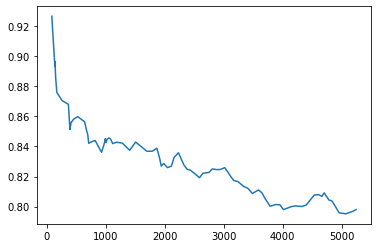

In [96]:
g.plot()

In [89]:
X_test.index.nunique()

956

In [93]:
X_test.index.value_counts().mean()

13.46234309623431

In [121]:
X_train.drop(["単勝","人気"],axis=1,inplace=True)
X_test.drop(["単勝","人気"],axis=1,inplace=True)

In [122]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
params={
    'num_leaves':4,
    'n_estimators':80,
    'class_weight':'balanced',
    'random_state':100
}
lgb_clf=lgb.LGBMClassifier(**params)
lgb_clf.fit(X_train.values,y_train.values)

LGBMClassifier(class_weight='balanced', n_estimators=80, num_leaves=4,
               random_state=100)

In [123]:
me=ModelEvaluator(lgb_clf,return_tables)
me.score(y_test,X_test)

0.70622606271777

In [124]:
g_tan2=gain(me.tansho_return,X_test)

  0%|          | 0/100 [00:00<?, ?it/s]

<AxesSubplot:>

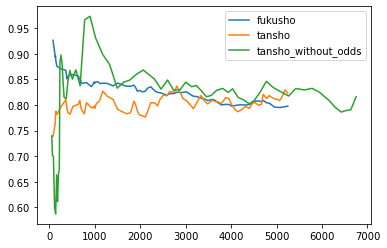

In [125]:
g.rename("fukusho").plot(legend=True)
gain_tansho.rename("tansho").plot(legend=True)
g_tan2.rename("tansho_without_odds").plot(legend=True)

In [126]:
g_tan2.max()

0.9738068812430632

In [127]:
me.feature_importance(X_test)

,features,importance
7,着順平均5R分,53
3,horse_id,29
8,賞金平均5R分,24
5,体重,14
223,jockey_id_05339,12
2,斤量,10
131,jockey_id_01088,10
13,peds_4,8
96,jockey_id_01014,6
227,jockey_id_05386,6
